In [1]:
!nvidia-smi

Thu Apr 30 10:32:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install kaggle
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle
!git clone https://github.com/ifayost/cdb_pneumonia.git
!python cdb_pneumonia/download_data.py
!mv chest_xray cdb_pneumonia
!python cdb_pneumonia/transform_images.py cdb_pneumonia/chest_xray
print('Done')

Cloning into 'cdb_pneumonia'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 19 (delta 7), reused 10 (delta 3), pack-reused 0
Unpacking objects: 100% (19/19), done.
100% 5216/5216 [02:25<00:00, 35.81it/s]
Done


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

plt.style.use('seaborn')

In [0]:
PATH = './cdb_pneumonia/chest_xray'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train':transforms.Compose([
        transforms.Resize((800,800)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()]),
    'val':transforms.Compose([
        transforms.Resize((800,800)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x), data_transforms[x])
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
class_samples = {x: np.sum([1 for _ in os.listdir(os.path.join(PATH, 'train', x))])
                for x in class_names}
weights = 1. / torch.tensor(list(class_samples.values()), dtype=torch.float).to(device)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True,
                                              batch_size=12, num_workers=2)
              for x in ['train', 'val']}

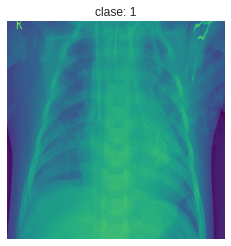

In [3]:
inputs, classes = next(iter(dataloaders['train']))
plt.imshow(inputs.numpy()[0,0], cmap='viridis')
plt.title(f'clase: {classes.numpy()[0]}');
plt.axis('off');

In [0]:
vgg16 = torchvision.models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
  param.requires_grad = False
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg16 = vgg16.to(device)

In [0]:
#vgg16.load_state_dict(torch.load('vgg16_800_800_10e.pt'))
#vgg16 = vgg16.to(device)

In [0]:
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001)

In [7]:
n_epochs = 10

train_loss, eval_loss = [],[]
for epoch in range(n_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            vgg16.train()
        else:
            vgg16.eval()
            
        for inputs, labels in tqdm(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg16(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    train_loss.append(loss.detach().to('cpu').numpy())
                else:
                    eval_loss.append(loss.to('cpu').numpy())

In [0]:
t_loss = np.array(train_loss)
e_loss = np.array(eval_loss)

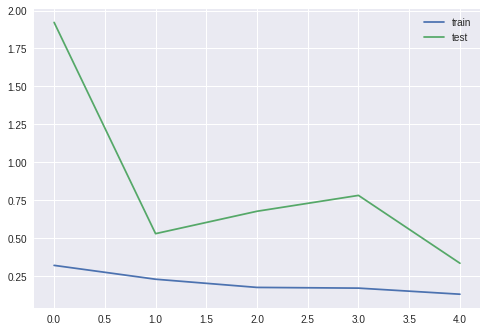

In [9]:
plt.plot(np.mean(t_loss.reshape(-1,len(t_loss)//5), axis=1), label='train');
plt.plot(np.mean(e_loss.reshape(-1,len(e_loss)//5), axis=1), label='test');
plt.legend();

In [0]:
#torch.save(vgg16.state_dict(), 'vgg16_800_800_10e.pt')

In [0]:
vgg16.eval()
aciertos = []
random = []
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    outputs = vgg16(inputs)
    _, preds = torch.max(outputs, 1)
    aciertos.extend([i==j for i,j in zip(preds.to('cpu').numpy(), labels.numpy())])
    random.extend([np.random.randint(0,1)== i for i in labels.numpy()])

In [11]:
print(f'VGG16 Accuracy: {np.sum(aciertos)/len(aciertos)}')
print(f'Random Accuracy: {np.sum(random)/len(random)}')

VGG16 Accuracy: 0.9375
Random Accuracy: 0.5
